# COGS 118A - Project Checkpoint

# Names

- Guanyu Zhu
- Tze Howe Yap
- David Chen
- Cassidy Lu

# Abstract 

Airbnb is a well known internet marketplace for short-term home and apartment rentals. Hosts often face difficulty in determining an optimal price for their listings. Both overpricing and underpricing can lead to revenue loss. To solve this problem, we use previews listed Airbnb in San Diego including their price and descriptions to encode those into machine learning models. 
 We aim to develop a model that can successfully predict Airbnb prices in San Diego based on relevant property features. We measure the model’s accuracy using R^2 and calculate the loss using RMSE. 

# Background

On May 5, 2023, the CDC announced the End of the Federal COVID-19 Public Health Emergency (PHE) Declaration, signaling an official end to this unprecedented pandemic. What's to come is the recovery of the global travel market. Across the entire world, there are currently over 4 million+ Airbnb hosts worldwide and 6 million+ active listings on the platform. In addition to the staggering number of hosts, there are more than 150 million users, and the overall number of bookings through Airbnb has surpassed 100 million.<a name="airbnbstats"></a>[<sup>[1]</sup>](#airbnbstats) In the area of San Diego alone, there are a total of 12,871 listings, with 87.1% of them being short-term rentals. Additionally, 66.3% of hosts have multiple listings, indicating that most hosts have more than one property on the market.<a name="airbnbsd"></a>[<sup>[2]</sup>](#airbnbsd) For those with a large number of listing properties, it becomes challenging to thoroughly investigate and change prices daily. Therefore, having a comparable prediction as a reference for their decision would be beneficial. The potential of the short-term rental market is enormous and growing exponentially. However, it's not just people with multiple listings who struggle with setting a fair price; new hosts also typically face difficulties when initially deciding on the price for their listings.

When you try to list your home on airbnb, you’ll need to do market research on the similar homes near you, finding out the average price of the market, and then determine the price that you would like to set for your home. The problem is that you can’t list a price and never change it forever. You need to change the price frequently based on market price, which means each time you want to change the price you need to do the market research again, which is a lot of work. In this case, if you have a program that can predict the price base on the model that has previously been trained on similar data from already existing listings would be pretty helpful. 


# Problem Statement

Setting a reasonable price for an airbnb host is hard to achieve. They need to predict other similar listings’ prices in order to maximize the profit. We aim to utilize machine learning algorithms to analyze past data and train a predictive model that can most accurately predict the most profitable airbnb price based on the property’s features and location. 


# Data

UPDATED FROM PROPOSAL!

You should have obtained and cleaned (if necessary) data you will use for this project.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


In [1]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import folium
from folium.plugins import HeatMap

In [2]:
# load in both dataframe
raw_listing = pd.read_csv('data/listings.csv.gz')
raw_calendar = pd.read_csv('data/calendar.csv.gz')

## Data Cleaning

In this section, we will clean and merge the two datasets we have chosen: 'listing.csv' and 'calendar.csv'. The 'listing.csv' dataset contains important features such as longitude, latitude, neighborhood, number of beds and bedrooms, and the accommodation capacity. The 'calendar.csv' dataset provides information on the availability and price for each unit.

Considering the computational limitations, we will only use a subset of the data, consisting of 50,000 records, out of the total dataset of over 2 million records. This selection will allow us to train our base model within the available computational resources.

Furthermore, we will focus our analysis on the period between June 1, 2023, and August 31, 2023. This period aligns with the summer vacation of college students and is of particular interest for our analysis.

### Listing 

In [3]:
# Get useful column assign to new dataframe
featured_listing = raw_listing[['id', 'host_location', 'neighbourhood_cleansed', 'latitude', 'longitude', 
                                'property_type', 'accommodates', 'bedrooms', 'beds',
                                'room_type', 'amenities']]

In [4]:
featured_listing.head()

,id,host_location,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,room_type,amenities
0,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3.0,3.0,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ..."
1,6,"San Diego, CA",North Hills,32.75522,-117.12873,Entire home,6,3.0,3.0,Entire home/apt,"[""Iron"", ""Security cameras on property"", ""Boar..."
2,29967,"San Diego, CA",Pacific Beach,32.80751,-117.25760,Entire bungalow,6,2.0,3.0,Entire home/apt,"[""Washer"", ""Hair dryer"", ""Iron"", ""Smoke alarm""..."
3,1166766,"San Diego, CA",Bay Park,32.78337,-117.19911,Entire home,14,5.0,6.0,Entire home/apt,"[""Washer"", ""Refrigerator"", ""Private hot tub"", ..."
4,1167130,"San Diego, CA",Old Town,32.74569,-117.18702,Entire home,12,5.0,7.0,Entire home/apt,"[""Washer"", ""Refrigerator"", ""Private hot tub"", ..."


In [5]:
# Asscess missingness
featured_listing.count()

id                        12871
host_location             10335
neighbourhood_cleansed    12871
latitude                  12871
longitude                 12871
property_type             12871
accommodates              12871
bedrooms                  11774
beds                      12707
room_type                 12871
amenities                 12871
dtype: int64

In [6]:
# Drop missing row 
featured_listing = featured_listing.dropna(subset=['bedrooms', 'beds'])

In [7]:
# converted column data types from the original DataFrame as we saw fit
str_lst = ['neighbourhood_cleansed', 'property_type', 'room_type']
for col in str_lst:
    featured_listing[col] = featured_listing[col].astype('string')

int_lst = ['bedrooms', 'beds']
for col in int_lst:
    featured_listing[col] = featured_listing[col].astype(int)
    
featured_listing.dtypes

id                          int64
host_location              object
neighbourhood_cleansed     string
latitude                  float64
longitude                 float64
property_type              string
accommodates                int64
bedrooms                    int64
beds                        int64
room_type                  string
amenities                  object
dtype: object

### Calendar 

In [8]:
# investigate two cloumns 'price' and 'adjusted_price'
raw_calendar[(raw_calendar['price'] != raw_calendar['adjusted_price'])].head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
5475,132966,2023-03-25,f,$100.00,$95.00,31,1120
5476,132966,2023-03-26,f,$100.00,$95.00,31,1120
5477,132966,2023-03-27,f,$100.00,$95.00,31,1120
5478,132966,2023-03-28,f,$100.00,$95.00,31,1120
5479,132966,2023-03-29,f,$100.00,$95.00,31,1120


In [9]:
# Get useful columns 
featured_calendar = raw_calendar[['listing_id', 'date', 'available', 'adjusted_price', 
                                  'minimum_nights', 'maximum_nights']]

In [10]:
featured_calendar.head()

,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights
0,610920,2023-03-25,f,$725.00,3,14
1,610920,2023-03-26,f,$725.00,3,14
2,610920,2023-03-27,t,$725.00,3,14
3,610920,2023-03-28,t,$725.00,3,14
4,610920,2023-03-29,t,$725.00,3,14


In [11]:
# Helper function to change columns type
def clean_price(price):
    return price.strip('$').replace(',', '')

def to_boolean(available):
    if available == 't':
        return True
    else:
        return False

In [12]:
# converted column data types from the original DataFrame as we saw fit 

featured_calendar['adjusted_price'] = featured_calendar['adjusted_price'].astype(str).apply(clean_price).astype(float)
featured_calendar['date'] = pd.to_datetime(featured_calendar['date'])
featured_calendar['available'] = featured_calendar['available'].astype(str).apply(to_boolean)

In [13]:
# get only the row where available equals to False
featured_stay_calendar = featured_calendar[featured_calendar['available'] == False]
featured_stay_calendar.head()

,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights
0,610920,2023-03-25,False,725.0,3,14
1,610920,2023-03-26,False,725.0,3,14
180,610920,2023-09-21,False,725.0,3,14
181,610920,2023-09-22,False,725.0,3,14
182,610920,2023-09-23,False,725.0,3,14


In [14]:
# Merge two dataframe
merged_df = featured_listing.merge(featured_stay_calendar, left_on = 'id', right_on = 'listing_id')
merged_df.head()

,id,host_location,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,room_type,amenities,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights
0,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-03-25,False,725.0,3,14
1,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-03-26,False,725.0,3,14
2,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-21,False,725.0,3,14
3,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-22,False,725.0,3,14
4,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-23,False,725.0,3,14


In [15]:
merged_df.shape

(2075782, 17)

In [16]:
# Assess missing data
merged_df.isna().any()

id                        False
host_location              True
neighbourhood_cleansed    False
latitude                  False
longitude                 False
property_type             False
accommodates              False
bedrooms                  False
beds                      False
room_type                 False
amenities                 False
listing_id                False
date                      False
available                 False
adjusted_price            False
minimum_nights            False
maximum_nights            False
dtype: bool

In [17]:
# Drop the row if adjusted price is missing 
merged_df.dropna(subset=['adjusted_price'])
merged_df.head()

,id,host_location,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bedrooms,beds,room_type,amenities,listing_id,date,available,adjusted_price,minimum_nights,maximum_nights
0,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-03-25,False,725.0,3,14
1,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-03-26,False,725.0,3,14
2,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-21,False,725.0,3,14
3,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-22,False,725.0,3,14
4,610920,"San Diego, CA",La Jolla,32.81244,-117.26835,Entire home,4,3,3,Entire home/apt,"[""Refrigerator"", ""Iron"", ""Security cameras on ...",610920,2023-09-23,False,725.0,3,14


In [18]:
# Drop the outlier in the dataset 

clean_merged = merged_df[(merged_df['adjusted_price'] <= np.percentile(merged_df['adjusted_price'], 99.5)) & \
                         ((merged_df['adjusted_price'] >= np.percentile(merged_df['adjusted_price'], 0.1))) & \
                         (merged_df['beds'] <= 30)]

In [19]:
# Choose one 50000 data from summer time of San Diego 
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-08-31')

filtered = (clean_merged['date'] >= start_date) & (clean_merged['date'] <= end_date)
filtered_df = clean_merged.loc[filtered]
filtered_df = filtered_df.sample(50000)

## Overview of Data

After completing all the data cleaning, we can utilize data visualization to obtain an overview of some important features that we care about. Firstly, we will examine the univariate distribution of price and neighborhood for each listing property. Then, we will perform bivariate analysis on selected features to gain a brief understanding of their relationship.

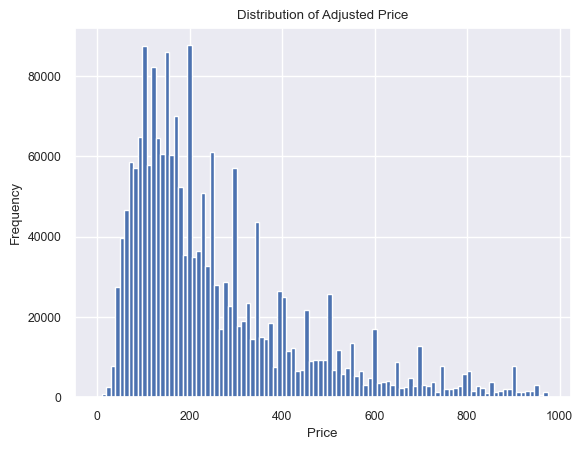

In [59]:
plt.hist(merged_df['adjusted_price'], range=[0,975], bins = 100)
plt.title("Distribution of Adjusted Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The range for the price in this histogram represents the 95th percentile of all the listing prices. From the histogram, it is evident that the majority of listing prices fall within the range of approximately $200$ to $400$ dollars per night.

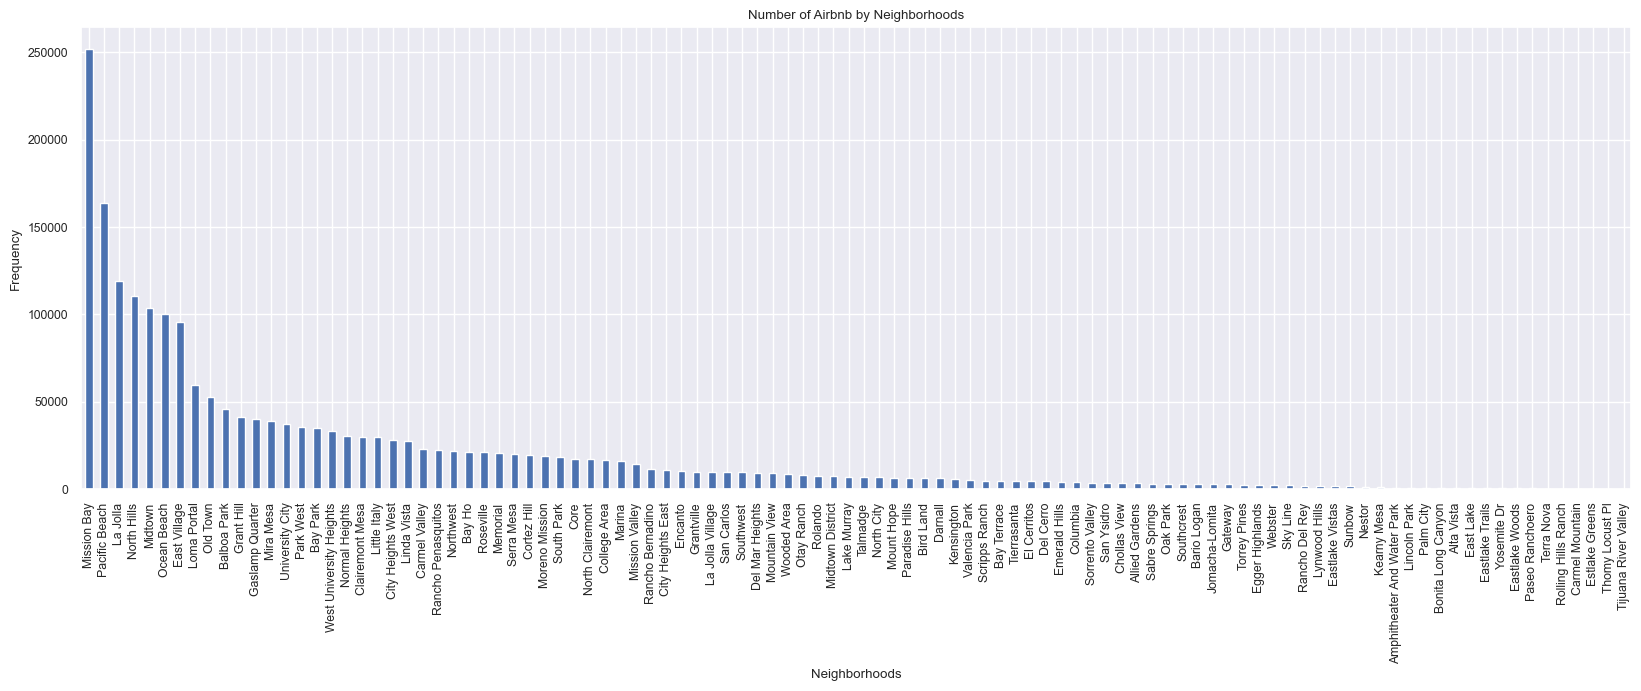

In [23]:
sns.set(font_scale = 0.8)
merged_df["neighbourhood_cleansed"].value_counts().plot(kind = 'bar', figsize=(20, 6))
plt.title("Number of Airbnb by Neighborhoods")
plt.xlabel("Neighborhoods")
plt.ylabel("Frequency")
plt.show()

The top five largest Airbnb neighborhoods in San Diego are Mission Valley, Pacific Beach, La Jolla, North Hills, and Midtown. These five neighborhoods collectively account for over 75% of the entire Airbnb listings in San Diego.

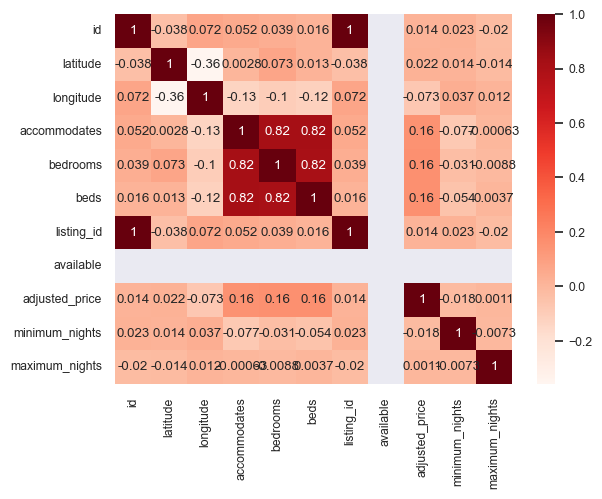

In [26]:
sns.heatmap(merged_df.corr(), annot = True, cmap = 'Reds')
plt.show()

This heatmap displays the bivariate relationships between each variable. However, no significant relationships were observed, except for the number of beds, bedrooms, and accommodation capacity, which is expected and not particularly informative.

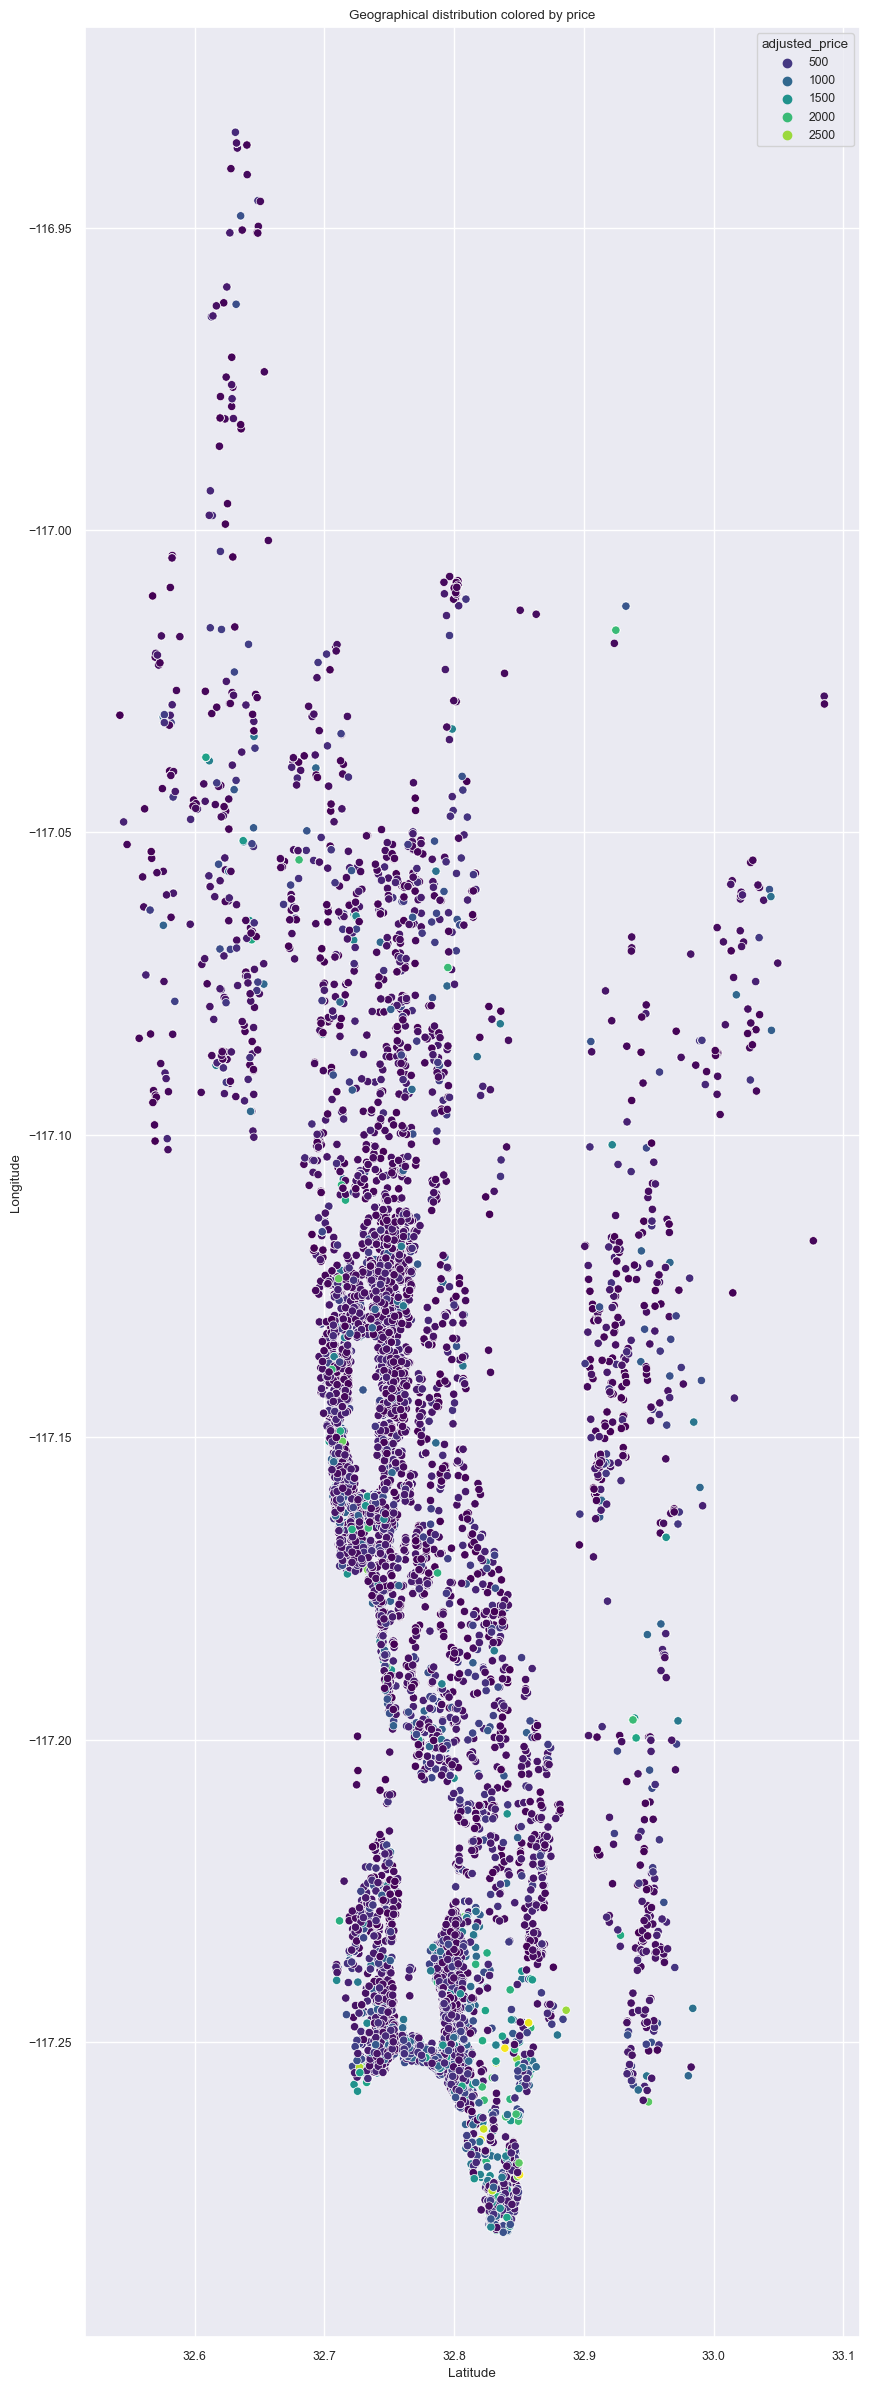

In [27]:
# Scatter plot for geolocation data colored by price
plt.figure(figsize=(10,30))
sns.scatterplot(x='latitude', y='longitude', hue='adjusted_price', palette='viridis', data=filtered_df)
plt.title('Geographical distribution colored by price')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

This scatter plot illustrates the relationship between longitude, latitude, and price. In the plot, lighter colors represent higher prices. It is evident that certain clusters, such as La Jolla and Midtown, contain a higher concentration of higher-priced listings.

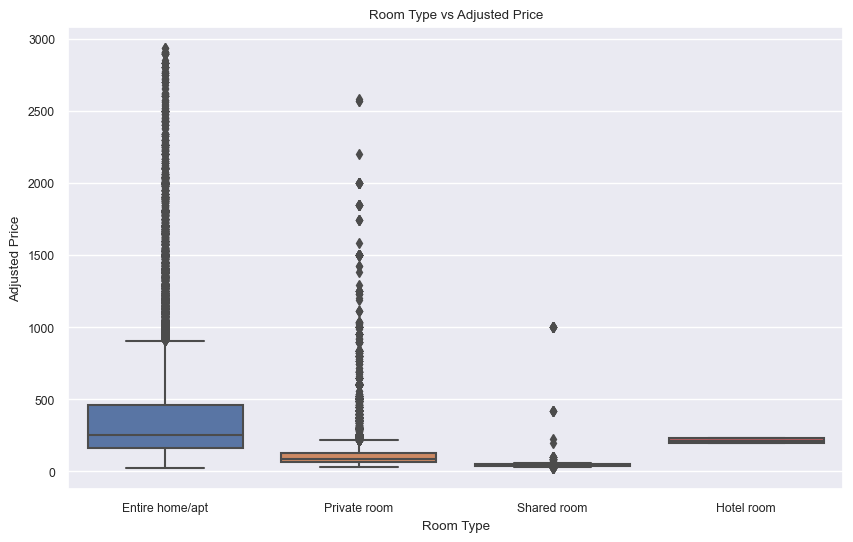

In [28]:
# Box plot for room_type and price
plt.figure(figsize=(10,6))
sns.boxplot(x='room_type', y='adjusted_price', data=filtered_df)
plt.title('Room Type vs Adjusted Price')
plt.xlabel('Room Type')
plt.ylabel('Adjusted Price')
plt.show()

In [29]:
# Heatmap graph to visualize locations 
heatmap = folium.Map(location=[featured_listing['latitude'].mean(), 
                               featured_listing['longitude'].mean()], 
                                zoom_start=10)


HeatMap(data=featured_listing[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().\
        reset_index().values.tolist(), radius=8, max_zoom=13).add_to(heatmap)

# for idx, row in featured_listing.iterrows():
#     folium.CircleMarker(location=(row['latitude'], row['longitude']), radius=1, 
#                         weight=2, color='green', fill_color='green', fill_opacity=.5).add_to(m)

heatmap

This heatmap is a visualization of location of listing property across San Diego area, which can be related to the previous scatter plot.

# Proposed Solution

We plan to build at least two models using Sklearn modules to compare their results for predicting airbnb prices in San Diego. Our thought is to use RandomForestRegressor model and polynomial regression model. Since our data consist of a decent amount of categorical variables as well as numerical variables, we will use one-hot encoding before putting all those data into two models. In order to test our model and to see how our models can generalize on unseen data, we will split our data into testing and training. For the training data, we will then use k-fold validation and GridSearchCV to make sure our data is not overfitting and tune our hyperparameter accordingly. 
Our General Plan as for now consist of those following step:
1. Data cleaning and using python and pandas
    - Drop out irrelevant features and data
    - Univariate Analysis
    - Bivariate Analysis
    - Assessment of Missingness 
2. Feature extraction using python and regex 
    - One-hot encoding for categorical features 
    - Assess numerical features and standardize relevant features 
3. Split the dataset into testing and training 
4. Build a baseline model 
5. Implement two models, use k-fold cross validation and GridSearchCV
6. After achieving good prediction use the best performed model on testing dataset

# Evaluation Metrics

An appropriate evaluation metric, such as Root Mean Square Error (RMSE) will be used to quantify the performance of the model. This metric quantifies the difference between predicted and actual prices, providing an indication of the model's accuracy. The Root Mean Square Error is calculated by the following formula:
$$
\text{RMSE}(y, \hat{y}) = \sqrt{\frac{\sum_{i=0}^{N - 1} (y_i - \hat{y}_i)^2}{N}}
$$
where N is the number of the data samples, $y_i$ is the ith measurement, and $\hat y_i$ is the corresponding predictions of the sample.


# Preliminary results

NEW SECTION!

Please show any preliminary results you have managed to obtain.

Examples would include:
- Analyzing the suitability of a dataset or alogrithm for prediction/solving your problem 
- Performing feature selection or hand-designing features from the raw data. Describe the features available/created and/or show the code for selection/creation
- Showing the performance of a base model/hyper-parameter setting.  Solve the task with one "default" algorithm and characterize the performance level of that base model.
- Learning curves or validation curves for a particular model
- Tables/graphs showing the performance of different models/hyper-parameters



### Feature Selection 

Before we begin building our base model, it is necessary to select features that are correlated with the price. We want to examine the relationship between the following features and price. The results have been attached.

- **Number of beds**
    - Positive correlated
- **Number of bedrooms**
    - Positive correlated
- **Number of accomodates**
    - Positive correlated
- **Minimum stay nights**
    - Not correlated
- **Longitude and Latitude**
    - Positive correlated

For categorical data, we will consider both the **neighborhood** and **room type**. The neighborhood is relevant as it has a direct relationship with safety, and the room type determines whether the guest needs to share their room with others. One-hot encoding will be use to process the categorical data.

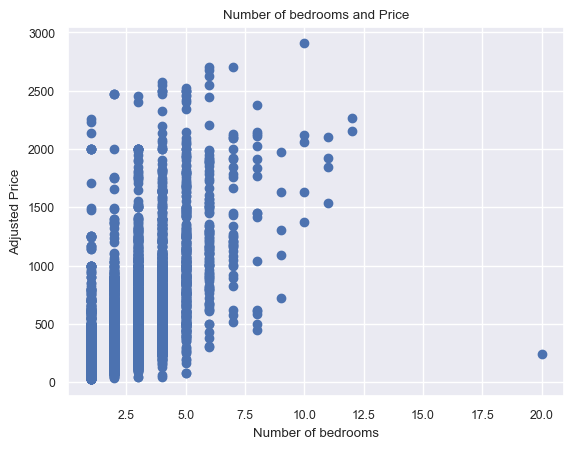

In [30]:
plt.scatter(x = clean_merged.groupby('id').mean().bedrooms, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Number of bedrooms and Price")
plt.xlabel("Number of bedrooms")
plt.ylabel("Adjusted Price")
plt.show()

The graph above displays a positive relationship between the number of bedrooms and the price. Although there is one outlier, it is evident that there is a clear positive linear relationship between the number of bedrooms and the price.

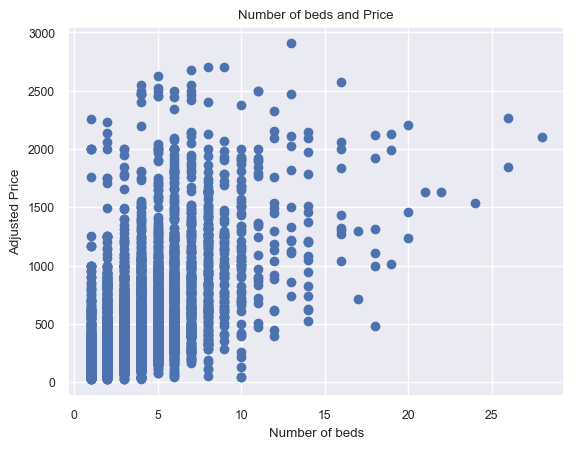

In [31]:
plt.scatter(x = clean_merged.groupby('id').mean().beds, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Number of beds and Price")
plt.xlabel("Number of beds")
plt.ylabel("Adjusted Price")
plt.show()

The graph above illustrates a positive relationship between the number of beds and the price. This relationship is not surprising, given that the previous graph indicated a direct relationship between the number of bedrooms and price. It is important to consider this factor because some travel groups with a lower budget may prioritize the number of beds when making their accommodation choice. The availability of multiple beds can be a decisive factor for such groups.

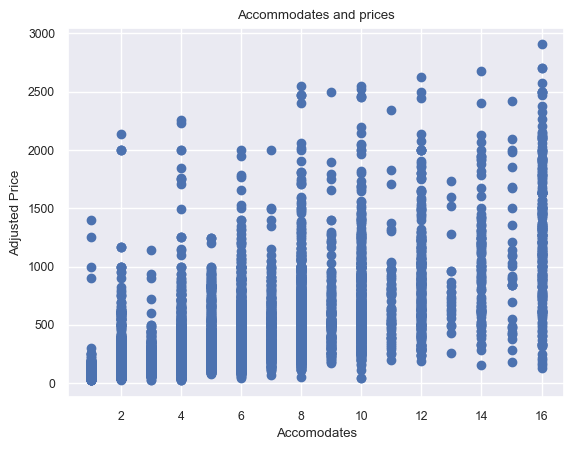

In [32]:
plt.scatter(x = clean_merged.groupby('id').mean().accommodates, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Accommodates and prices")
plt.xlabel("Accomodates")
plt.ylabel("Adjusted Price")
plt.show()

The above graph demonstrates a positive relationship between the number of people the listing can accommodate and the price.

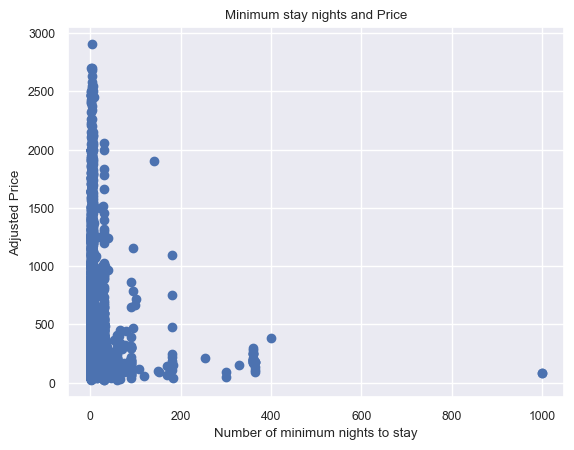

In [33]:
plt.scatter(x = clean_merged.groupby('id').mean().minimum_nights, y = clean_merged.groupby('id').mean().adjusted_price)
plt.title("Minimum stay nights and Price")
plt.xlabel("Number of minimum nights to stay")
plt.ylabel("Adjusted Price")
plt.show()

The above graph depicts the relationship between the number of minimum nights staying and the price. No obvious relationship can be observed from the graph.

In [34]:
from mpl_toolkits.mplot3d import Axes3D

/var/folders/mh/fxqngtrx5t99493pfstpfm4h0000gn/T/ipykernel_9578/580396984.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = ax = Axes3D(fig)


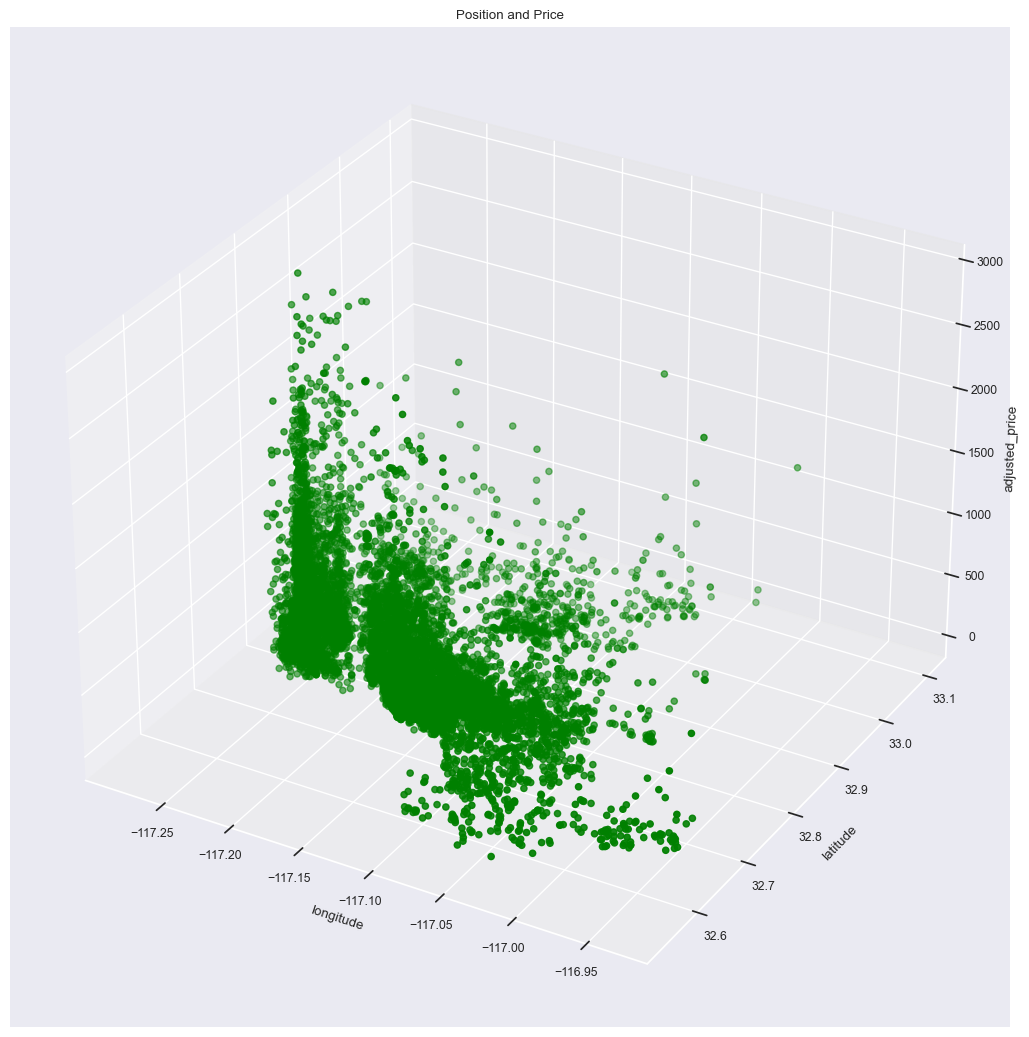

In [35]:
fig = plt.figure(figsize = (10, 30))
ax = ax = Axes3D(fig)
 
# Creating plot
ax.scatter3D(clean_merged.groupby('id').mean().longitude, 
             clean_merged.groupby('id').mean().latitude, 
             clean_merged.groupby('id').mean().adjusted_price,
             color = "green")
ax.set_title("Position and Price")
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('adjusted_price')

plt.show()

The above 3-D graph provides a geographic visualization of the relationship between location and price. It is evident that certain clusters exhibit higher prices. This observation serves as additional support for our selection of features, indicating that location plays a role in determining the price of listings.

### Base model 

For the base model, we will use 2 models: **Linear Regression** and **KNN**. At this time, we will use basic rmse as our primary guideline for model selection.

### Linear Regression

The features we use for Linear Regression Model are neighbourhood_cleansed, accomodates, and beds.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [37]:
# Define a rmse function for calculating error 
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

In [38]:
# Base model with neighbourhood_cleansed, accommodates, beds features 

# Split testing and trainning set 
X_base = clean_merged[['neighbourhood_cleansed', 'accommodates', 'beds']]
y_base = clean_merged['adjusted_price']
X_train, X_test, y_train, y_test = train_test_split(X_base, y_base, test_size=0.25)

In [39]:
# Column transformer 
preproc = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['neighbourhood_cleansed']), 
        ('std', StandardScaler(), ['accommodates', 'beds'])
    ],
    remainder = 'passthrough'
)

In [40]:
# Creating the base model pipleline 
base_pl = Pipeline([('pre', preproc), ('lin-reg', LinearRegression())])
base_pl.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['neighbourhood_cleansed']),
                                                 ('std', StandardScaler(),
                                                  ['accommodates', 'beds'])])),
                ('lin-reg', LinearRegression())])

In [41]:
print(base_pl.score(X_train, y_train), base_pl.score(X_test, y_test))

0.49353174574733993 0.49290419357308823


In [42]:
print(rmse(base_pl.predict(X_train), y_train), rmse(base_pl.predict(X_test), y_test))

226.114653059615 225.05444261902204


### K-Nearest Neighbor
The features we use for KNN model are room types, accommodates, day of weeks, neighbourhood_cleansed, and beds. We will do seperate training 20 times with increment k.

In [43]:
filtered_df['day_of_week'] = filtered_df['date'].dt.dayofweek

In [60]:
# Split testing and trainning set 
X_sec = filtered_df[['accommodates', 'room_type', 'day_of_week', 'neighbourhood_cleansed', 'beds']]
y_sec = filtered_df['adjusted_price']
X_train, X_test, y_train, y_test = train_test_split(X_sec, y_sec, test_size=0.25)

In [61]:
from sklearn.neighbors import KNeighborsRegressor

In [62]:
# Column transformer 
preproc = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ['room_type', 'neighbourhood_cleansed']), 
        ('std', StandardScaler(), ['accommodates'])
    ],
    remainder = 'passthrough'
)

In [63]:
from tqdm import tqdm

In [64]:
errs_df = pd.DataFrame()
train_err_lst = []
test_err_lst = []

train_score = []
test_score = []

for n_neighbors in tqdm(range(1, 21)):
    dt = Pipeline([('pre', preproc), ('knn', KNeighborsRegressor(n_neighbors))])
    dt.fit(X_train, y_train)
    sc = dt.score(X_train, y_train)
    train_score.append(sc)
    train_err_lst.append(rmse(dt.predict(X_train), y_train))

    sc_test = dt.score(X_test, y_test)
    test_score.append(sc_test)
    test_err_lst.append(rmse(dt.predict(X_test), y_test))
    


100%|███████████████████████████████████████████| 20/20 [30:01<00:00, 90.08s/it]


In [65]:
train_score

[0.5289404800175275,
 0.6301161551343817,
 0.6486977598173944,
 0.6540636361376323,
 0.651908203736429,
 0.6488444335465091,
 0.6407867352714134,
 0.6395632312367143,
 0.6356369339851922,
 0.6322188688499355,
 0.6273486765624506,
 0.6240399758722917,
 0.6206964034368316,
 0.6179317218098288,
 0.6143785715281008,
 0.610652249191285,
 0.6082378791287255,
 0.6064735247764463,
 0.6042575076321479,
 0.6022651140688241]

In [66]:
test_score

[0.3465386419369295,
 0.47518403968252254,
 0.5209048327430716,
 0.537908400116837,
 0.5497133741537205,
 0.5581208438411465,
 0.5576637478191939,
 0.5626382662391676,
 0.5664435761133275,
 0.5672512660394065,
 0.5650821099865797,
 0.565145279597103,
 0.5652076726058061,
 0.5676660740546697,
 0.5685399206257145,
 0.5703658738020894,
 0.570446115530282,
 0.5696815926112127,
 0.5699824746820281,
 0.5692546692250057]

In [67]:
test_err_lst

[281.8489967340668,
 252.58645327887243,
 241.33340073664144,
 237.0121307549468,
 233.96509038059486,
 231.77057368105423,
 231.8904186912784,
 230.58281083756006,
 229.57751489030926,
 229.36357054946635,
 229.93769524779523,
 229.92099600128446,
 229.90450086320513,
 229.25361683924987,
 229.0218124319168,
 228.53668471590615,
 228.51534209698562,
 228.71860827199123,
 228.63863335002333,
 228.83203720545765]

### Error Analysis for KNN
Based on the training results from the 20 separate training runs of the KNN model, we interpreted the results using a graph.

As this is our base model using only 50,000 data points, the results are quite satisfactory. While a few models exhibited slightly lower accuracy, the majority of models performed well, with a test score of over 0.55.

In [79]:
# plt.plot(train_score,test_score)
# plt.xlabel('train score')
# plt.ylabel('test score')
# plt.show()

In [80]:
# plt.plot(train_err_lst,test_err_lst)
# plt.xlabel('train error')
# plt.ylabel('test error')
# plt.show()

In [76]:
# plt.plot(test_score,test_err_lst)
# plt.xlabel('value of k for knn')
# plt.ylabel('Error')
# plt.show()

The graph below shows a relationship between training and testing score and k neighbors. As we increase k, we can observe a decrease in training score after k > 3. However, the testing score increase continuously as k gets larger. 

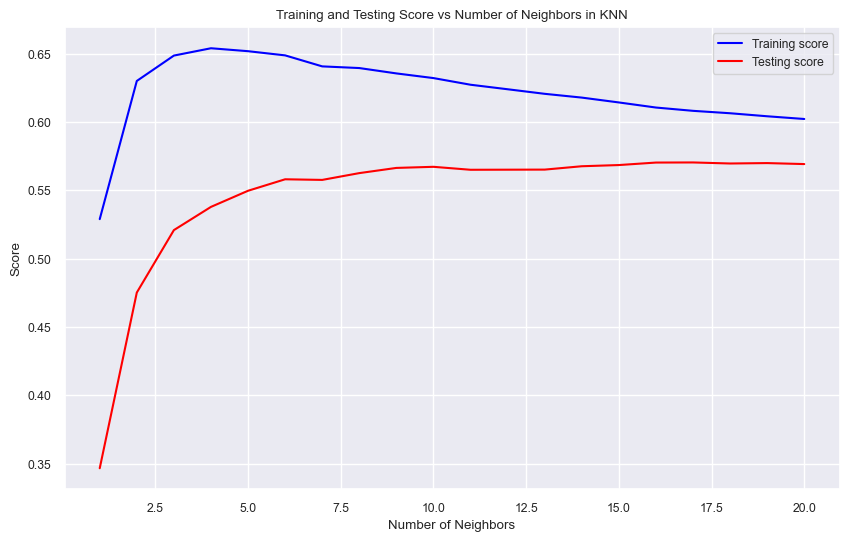

In [72]:
# Convert lists to numpy arrays for easier manipulation
train_score = np.array(train_score)
test_score = np.array(test_score)

# Create an array with the number of neighbors
neighbors = np.arange(1, 21)

# Create the plot
plt.figure(figsize=(10,6))

# Plot training accuracy
plt.plot(neighbors, train_score, label="Training score", color='blue')

# Plot test accuracy
plt.plot(neighbors, test_score, label="Testing score", color='red')

# Create labels
plt.title("Training and Testing Score vs Number of Neighbors in KNN")
plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.legend()

# Show the plot
plt.show()


In [81]:
# plt.figure(figsize=(21, 6))
# plt.plot(neighbors, train_err_lst, label='Training error')
# plt.plot(neighbors, test_err_lst, label='Testing error')
# plt.xlabel('Number of neighbors')
# plt.ylabel('RMSE')
# plt.title('KNN Model - Training and Testing error vs. Number of Neighbors')
# plt.legend()
# plt.show()


In [82]:
# convert list to numpy array for efficient calculations
test_err_lst = np.array(test_err_lst)

# get the index that gives the minimum error on the testing data
optimal_k = np.argmin(test_err_lst) + 1  # we add 1 because index starts from 0 but our k values start from 1

print(optimal_k)

17


The above cell provides the optimal value of **k = 17**. Means that when we choose k = 17, the test set error for our model will be smallest.

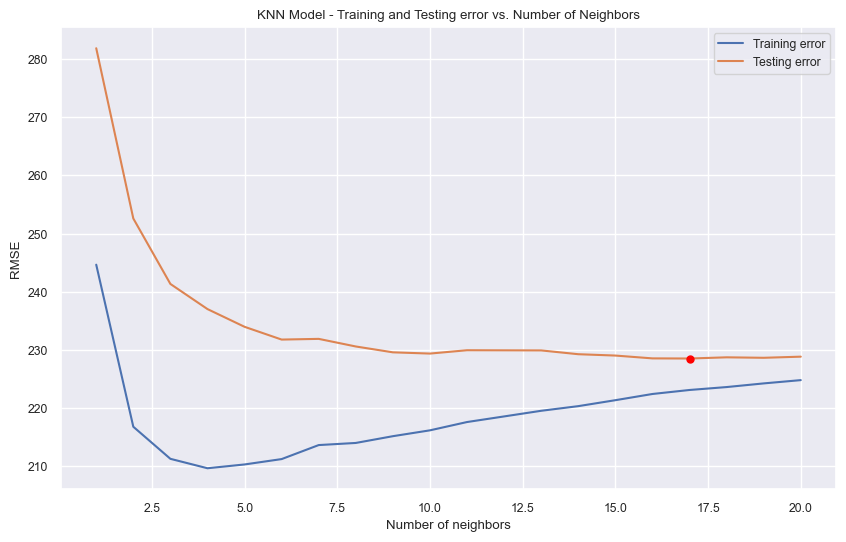

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_err_lst, label='Training error')
plt.plot(range(1, 21), test_err_lst, label='Testing error')

# Add a red dot for optimal k
plt.plot(optimal_k, min(test_err_lst), marker='o', markersize=5, color="red")

plt.xlabel('Number of neighbors')
plt.ylabel('RMSE')
plt.title('KNN Model - Training and Testing error vs. Number of Neighbors')
plt.legend()
plt.show()


# Ethics & Privacy

- Data Collection:
    - Informed consent:
Our dataset is extracted from official documentation published by Airbnb. The information can be searched online and hosts sign a form of consent when the properties are listed on the market, so there should not be any legal issues.
    - Collection bias:
The dataset is comprehensively collected from every single listing in the area of San Diego. So, there is no foreseeable bias in the process of data collection.
    - Limit PII exposure:
The dataset contains names of the hosts, so we will delete the sensitive information such as their ID and names of the hosts in the data cleaning processes.


- Data Storage
    - Data Security and Right to be forgotten
In compliance with regulations such as the GDPR, we respect the 'right to be forgotten.' If an individual whose data is included in our project requests for their data to be erased, we are obligated to do so, provided there are no legal grounds for retaining it. This helps to ensure that individuals maintain control over their personal data.
    - Data retention plan:
We recognize the importance of not retaining data longer than necessary. Our default position will be to retain data for only as long as it is required for the purpose of the project. Once the data is no longer necessary, we will safely and securely delete it.


- Analysis
    - Missing perspectives
For this project, we do not obtain the source of expertise knowledge or any affected communities. 
    - Dataset bias: 
Our datasets record the fundamental features of listings in San Diego are. The data it contained does not contain any information that can be related to stereotype perpetuation or imbalance classes. One variable that might be confounding in our dataset is “license”. According to our research, Airbnb's official forum provides information regarding this feature. Excerpting from Airbnb’s official response: “Some cities require Hosts to obtain a license or registration number to list their places on Airbnb. The corresponding field on their listing allows them to show that number for compliance.” This provides us an understanding of what a license is and how it applies to the property listing. Additionally, Airbnb also suggests that “license” might not be necessary for some cities, depending on the policies. For those properties that have status ‘city registration pending’ or ‘exempt’, Airbnb claims that it will not affect the veracity and safety of the listings.
    - Honest Representation:
Our visualizations, summary statistics, and reports will honestly represent the underlying data.
    - Privacy in Analysis:
Yes, we will remove the data that are related to IDs or host name in the data cleaning process.
    - Auditability:
Yes, the process will be able to reproduce using the dataset we provides and the technique we used. 



- Modeling
    - Proxy Discrimination:
We will ensure that the model does not inadvertently result in discrimination through the use of proxy variables - variables that correlate with protected characteristics such as race, age, or gender.
    - Fairness across groups:
We will prioritize fairness across all groups to ensure that no one group will receive favor based on any characteristics. We will utilize techniques to check if our model is biased, and if it is, we will mitigate it and re-evaluate our model.
    - Metric selection:
RMSE
    - Explainability:
We aim to choose a model that achieves a balance between explainability and accuracy. While more complex models offer better accuracy and predictiveness, it will more often be harder to explain. It is important for us to understand how a model is making its decisions.


- Deployment
    - Monitoring and evaluation:
Once the model is deployed, there is a need to monitor the performance and fairness continuously. We will track metrics like the model’s accuracy and potential bias over time and across different groups.
Redress
    - Roll back:
A roll-back plan will be in place to revert to a previous version of the model or even to stop using the model altogether if serious issues arise. This could be necessary if the model starts performing poorly or if significant bias is discovered that can't be quickly mitigated. 
    - Redress:
We will officially apologize to those who are harmed by our project and provide contact information for them to reach out for a solution
    - Unintended use:
Some unintended use for our project can be customers/guests using our results to argue with the host for lower prices, which might have negative effects on the revenue of listing properties.


# Team Expectations 

Put things here that cement how you will interact/communicate as a team, how you will handle conflict and difficulty, how you will handle making decisions and setting goals/schedule, how much work you expect from each other, how you will handle deadlines, etc...
* *All team members actively engage in the discussion of our project*
* *All team members have completed their respective tasks on time while maintaining a high standard of quality in their work*
* *All team members contribute equally to solution and information research*

# Project Timeline Proposal

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 5/10  |  7-8 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 5/15  |  5-8 PM |  Do background research on topic (all) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 5/17  | 4-8 PM  | Edit, finalize, and submit proposal; Search for datasets (all)  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part   |
| 5/21  | 11-12 PM  | First meeting on feature selection, data cleaning | Feature selection completed |
| 5/30  | 3-7 PM  | Second meeting on feature selection, data cleaning | Base Model completed |

# Footnotes
<a name="airbnbstats"></a>1.[^](#airbnbstats): “Airbnb Statistics [2023]: User & Market Growth Data.” SearchLogistics, 28 Apr. 2023, www.searchlogistics.com/learn/statistics/airbnb-statistics/. <br>
<a name="airbnbsd"></a>2.[^](#airbnbsd): “San Diego.” Inside Airbnb: Home, insideairbnb.com/san-diego. Accessed 17 May 2023. 
